In [ ]:
import sys
!{sys.executable} -m pip3 install pandas
!{sys.executable} -m pip3 install numpy

In [2]:
import pandas
from sklearn import tree
import numpy as np
from sklearn.model_selection import train_test_split

###### Read and show data

In [4]:
train_data = pandas.read_csv('titanic/train.csv', index_col='PassengerId')
test_data = pandas.read_csv('titanic/test.csv', index_col='PassengerId')
print(test_data.shape)
test_data.head()

(418, 10)


,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


###### Convert values in data to numeric values

In [5]:
def convert_non_numerical(data):
    """ This function converts non numeric values to numeric values """
    new_data = data.copy()
    columns = list(data.columns)
    for column in columns:
        if str(data[column].dtype) not in ['int64', 'float64']:
            all_values = data[column].values
            unique_values = list(set(all_values))
            new_values = [unique_values.index(value) for value in all_values]
            new_data[column] = new_values
#     print(data.isna())
    new_data[data.isna()] = np.nan
    return new_data
train_numeric = convert_non_numerical(train_data)
train_numeric.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,698,0,22.0,1,0,446,7.2500,NaN,1.0
2,1,1,430,1,38.0,1,0,429,71.2833,102.0,3.0
3,1,3,599,1,26.0,0,0,146,7.9250,NaN,1.0
4,1,1,137,1,35.0,1,0,108,53.1000,28.0,1.0
5,0,3,568,0,35.0,0,0,262,8.0500,NaN,1.0


##### Check number of nan in 'cabin' feature

In [6]:
# Because in 687 rows have Cabin=nan, first we delete Cabin column
print('Data:')
print('number of all rows in training data: ' + str(train_numeric.shape[0]))
print('number of rows contain Cabin=nan in training data: ' + str(train_numeric['Cabin'].isna().sum()))
train_drop_cabin = train_numeric.drop('Cabin', axis=1)
print('number of rows after droping "Cabin" in training data: ' + str(len(train_numeric)))

Data:
number of all rows in training data: 891
number of rows contain Cabin=nan in training data: 687
number of rows after droping "Cabin" in training data: 891


###### Fill nan values in data with tow method: 1) using value of neares row 2) using mean of that column

In [7]:
def fill_nan_with_nearest(data_with_nan, train_data):
    """ This function gets data that has nan value and train data that is used to get nearest row 
        and for any nan value use value of nearest row to that row 
    """
    nan_cols = train_data.isna().sum()
    filled_col = [col for col in nan_cols.keys() if nan_cols[col]==0]
    for index, row in data_with_nan[data_with_nan.isna().any(axis=1)].iterrows():  # iterate all row with nan value
        dist_per_row = {}
        for index2, row2 in train_data[~train_data.isna().any(axis=1)].iterrows():  # iterate all row without nan value
            dist_per_row[index2] = np.array([row[v] for v in filled_col]).T @ np.array([row2[v] for v in filled_col])
        nearest_row_id = min(dist_per_row, key=lambda x:dist_per_row[x])
        for attr in row[row.isna()].keys():
            data_with_nan.at[index, attr] = train_data.at[nearest_row_id, attr]
    return data_with_nan

def fill_nan_with_mean(data):
    """ This functions gets data and fill nan values with mean in that column """
    for col in data.columns:
        mean_value=data[col].mean()
        data[col].fillna(value=mean_value, inplace=True)
    return data

###### evaluate results by calculating precision and recall

In [9]:
def evaluate_results(predicteds, labels):
    """ This function gets predicted class and real labels and then evaluates that results """
    confusion_matrix = {'FP':0, 'FN':0, 'TP':0, 'TN':0}
    for i, predicted in enumerate(predicteds):
        if labels[i] == 1:
            if predicted == 1:
                confusion_matrix['TP'] += 1
            else:
                confusion_matrix['FN'] += 1
        else:
            if predicted == 1:
                confusion_matrix['FP'] += 1
            else:
                confusion_matrix['TN'] += 1
    precision = confusion_matrix['TP']/(confusion_matrix['TP']+confusion_matrix['FP'])
    recall = confusion_matrix['TP']/(confusion_matrix['TP']+confusion_matrix['FN'])
    F1 = 2*(precision*recall)/(precision+recall)
    print('\t precision: ' + str(precision))
    print('\t recall: ' + str(recall))
    print('\t F1: ' + str(F1))
    return F1

###### Create decision tree for training data and evaluate in test data

In [10]:
def decision_tree(method, depth, train, test):
    """ This function gets depth and method of tree and then creating tree for training data """
    dt = tree.DecisionTreeClassifier(criterion=method, max_depth=depth)
    train_labels = train['Survived']
    train_data = train.drop('Survived', axis=1)
    test_labels = test['Survived']
    test_data = test.drop('Survived', axis=1)

    dt = dt.fit(train_data, train_labels)
    
    predicteds = dt.predict(test_data)
    score = evaluate_results(predicteds, test_labels.values)
    return score

###### Preprocess test data as we do for train data using above functions

In [11]:
def preprocess_data(data, train_data):
    data_numeric = convert_non_numerical(data)
    data_drop_cabin = data_numeric.drop('Cabin', axis=1)
    data_numeric_filled_nan_nearest = fill_nan_with_nearest(data_drop_cabin, train_data)  # first method for fill nan
    data_numeric_filled_nan_mean = fill_nan_with_mean(data_drop_cabin)  # second method fill nan
    return data_numeric_filled_nan_nearest, data_numeric_filled_nan_mean

###### Splite train data to train and validation to find best depth of tree and best method for filling nan values

In [13]:
data = train_data.sample(frac=1).reset_index(drop=True)  # shuffeling data
train , validation = data[:int(len(data)*0.8)], data[int(len(data)*0.8):]  # spliting data
train_numeric_filled_nan_nearest, train_numeric_filled_nan_mean = preprocess_data(train, train_drop_cabin)
val_numeric_filled_nan_nearest, val_numeric_filled_nan_mean = preprocess_data(validation, train_drop_cabin)

###### Create tree per method and deph and calculate F1 measure for them

In [14]:
method = 'entropy'
print("#### Using nearest row to fill nan vslues ####")
method_score = {}
for i in range(1, 10):
    depth = i
    print("depth: " + str(i))
    score = decision_tree(method, depth, train_numeric_filled_nan_nearest, val_numeric_filled_nan_nearest)
    method_score[str(i) + ' nearest'] = score
print("\n#### Using mean to fill nan vslues ####")
for i in range(1, 10):
    depth = i
    print("depth: " + str(i))
    score = decision_tree(method, depth, train_numeric_filled_nan_mean, val_numeric_filled_nan_mean)
    method_score[str(i) + ' mean'] = score

#### Using nearest row to fill nan vslues ####
depth: 1
	 precision: 0.7333333333333333
	 recall: 0.6376811594202898
	 F1: 0.6821705426356589
depth: 2
	 precision: 0.9354838709677419
	 recall: 0.42028985507246375
	 F1: 0.58
depth: 3
	 precision: 0.7619047619047619
	 recall: 0.6956521739130435
	 F1: 0.7272727272727272
depth: 4
	 precision: 0.7333333333333333
	 recall: 0.6376811594202898
	 F1: 0.6821705426356589
depth: 5
	 precision: 0.746031746031746
	 recall: 0.6811594202898551
	 F1: 0.7121212121212122
depth: 6
	 precision: 0.7142857142857143
	 recall: 0.6521739130434783
	 F1: 0.6818181818181819
depth: 7
	 precision: 0.711864406779661
	 recall: 0.6086956521739131
	 F1: 0.6562500000000001
depth: 8
	 precision: 0.7241379310344828
	 recall: 0.6086956521739131
	 F1: 0.6614173228346457
depth: 9
	 precision: 0.7058823529411765
	 recall: 0.5217391304347826
	 F1: 0.6

#### Using mean to fill nan vslues ####
depth: 1
	 precision: 0.7333333333333333
	 recall: 0.6376811594202898
	 F1: 0.682170542

###### Select best method accourding to F1 measures

In [16]:
best_method = max(method_score, key= lambda x:method_score[x])
best_depth, best_fill_nan_method = best_method.split()
print('Best method for filling nan values: ' + best_fill_nan_method)
print('Best depth for tree: ' + best_depth)

Best method for filling nan values: nearest
Best depth for tree: 3


###### Train decision tree with best parameters

Tree with 3 depth


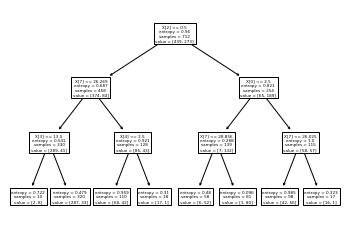

In [17]:
dt = tree.DecisionTreeClassifier(criterion=method, max_depth=int(best_depth))
train_labels = train_numeric_filled_nan_nearest['Survived']
train_data = train_numeric_filled_nan_nearest.drop('Survived', axis=1)
dt = dt.fit(train_data, train_labels)
tree.plot_tree(dt)
print('Tree with {} depth'.format(best_depth))

###### Predict labels of test data using trained decision tree after preprocessing test data 

In [18]:
preprocessed_test, _ = preprocess_data(test_data, train_drop_cabin.drop('Survived', axis=1))
predicteds = dt.predict(preprocessed_test)
test_with_labels = test_data.copy()
test_with_labels['Survived'] = predicteds
test_with_labels.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
PassengerId,,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1
